# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on mouse NAc cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata
import scipy.io
import scipy.sparse

import time
import os, wget


import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import cuml
import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)
from scipy import sparse
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()
import calculation_tool as ct

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

## load data

In [ ]:
import os
import scanpy as sc
import pandas as pd
from scipy import sparse
import anndata

def load_and_merge_data_v3(base_dir):
    # 処理する条件（controlとschizophrenia）をリストとして定義
    conditions = ['control', 'schizophrenia']
    
    count = 0
    for condition in conditions:
        condition_path = os.path.join(base_dir, condition)
        
        # 各条件下でのサンプル名（MB7、MB8など）を取得
        samples = os.listdir(condition_path)
        
        for sample in samples:
            sample_path = os.path.join(condition_path, sample, 'matrix.tsv')
            
            # pandasでTSVファイルを読み込み
            if count == 0:
                adata=sc.read_csv(sample_path,delimiter='\t').T
                sparse_X = sparse.csr_matrix(adata.X)
                adata.X = sparse_X
                adata.obs['condition'] = condition
                adata.obs['sample'] = sample
            else:
                adata_append = sc.read_csv(sample_path,delimiter='\t').T
                sparse_X = sparse.csr_matrix(adata_append.X)
                adata_append.X = sparse_X
                adata_append.obs['condition'] = condition
                adata_append.obs['sample'] = sample
            
                # 連結
                adata = anndata.concat([adata, adata_append])
                print(adata.X.shape)
            
            count += 1
            
    return adata

base_dir = '/temp/data/human_Sz_PFC_each'
#adata = load_and_merge_data_v3(base_dir)
file_path="/temp/data/human_Sz_PFC_each/merged_adata.h5ad"
#adata.write(file_path)

In [ ]:
base_dir = '/data/human_Sz_PFC_each'
#adata = load_and_merge_data_v3(base_dir)
file_path="/data/human_Sz_PFC_each/merged_SZ_adata.h5ad"
adata = anndata.read_h5ad(file_path)
print(adata.X.shape)

In [ ]:
file_path="/data/human_Sz_PFC_each/merged_control_adata.h5ad"
adata = anndata.read_h5ad(file_path)

In [ ]:
inc_list=['MB7','MB9','MB11', 'MB13', 'MB15', 'MB16', 'MB17']

In [ ]:
adata2=adata[adata.obs['sample'].isin(inc_list)]

In [ ]:
adata2.write("/data/human_Sz_PFC_each/merged_control_selected_adata.h5ad")

In [ ]:
file_path="/data/human_Sz_PFC_each/merged_control_selected_adata.h5ad"
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,is_gpu=False)
GPCR_df.to_csv("/data/human_Sz_PFC_each/control_selected_combined_data_GPCR_df.csv")

In [2]:
GPCR_df=pd.read_csv("/data/human_Sz_PFC_each/control_selected_combined_data_GPCR_df.csv")
adata=anndata.read_h5ad("/data/human_Sz_PFC_each/merged_control_selected_adata_processed.h5ad")

In [3]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)

Drug concentration: 0.001
clz selective cells
# of clz selective cells: is_clz_selective
False    54002
True      2882
Name: count, dtype: int64


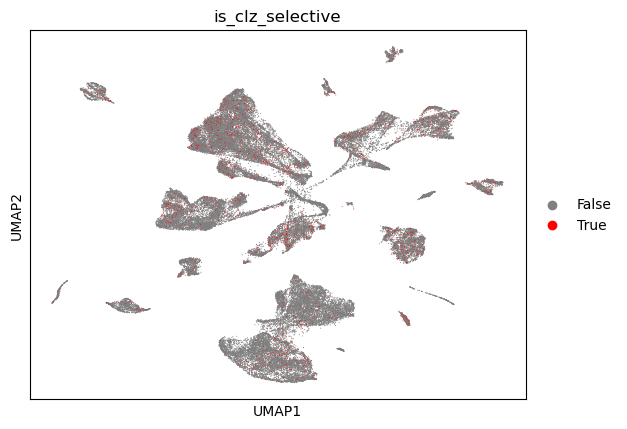

Drug concentration: 0.01
clz selective cells
# of clz selective cells: is_clz_selective
False    54002
True      2882
Name: count, dtype: int64


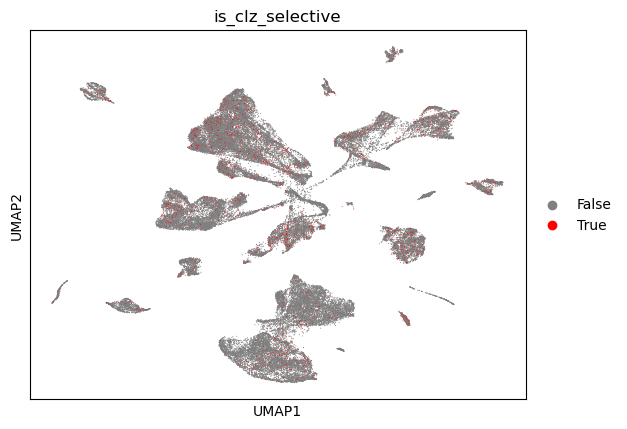

Drug concentration: 0.1
clz selective cells
# of clz selective cells: is_clz_selective
False    54001
True      2883
Name: count, dtype: int64


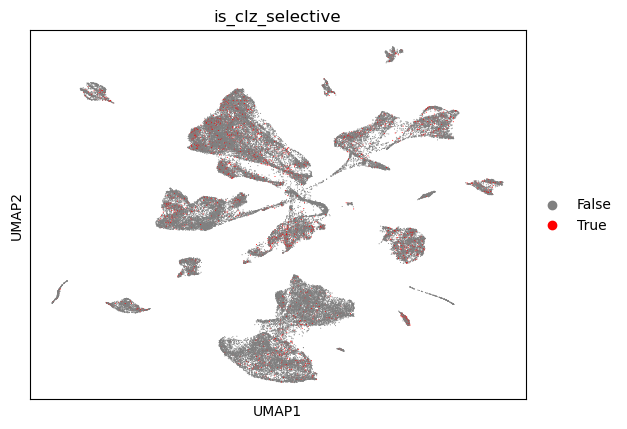

Drug concentration: 1
clz selective cells
# of clz selective cells: is_clz_selective
False    53932
True      2952
Name: count, dtype: int64


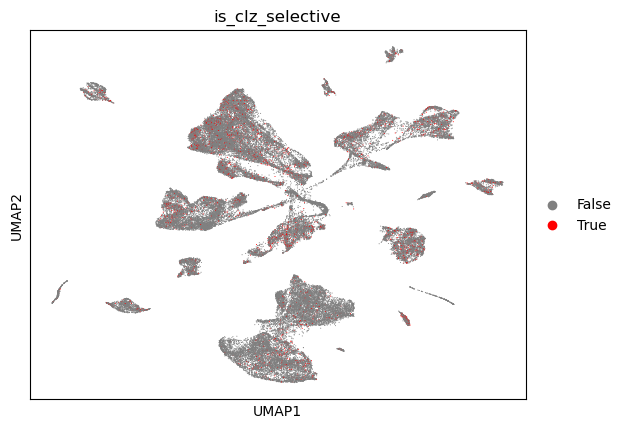

Drug concentration: 1.5848931924611136
clz selective cells
# of clz selective cells: is_clz_selective
False    53824
True      3060
Name: count, dtype: int64


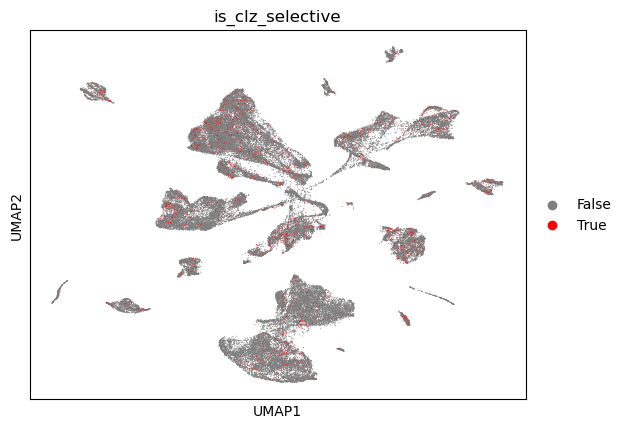

Drug concentration: 2.2387211385683394
clz selective cells
# of clz selective cells: is_clz_selective
False    53657
True      3227
Name: count, dtype: int64


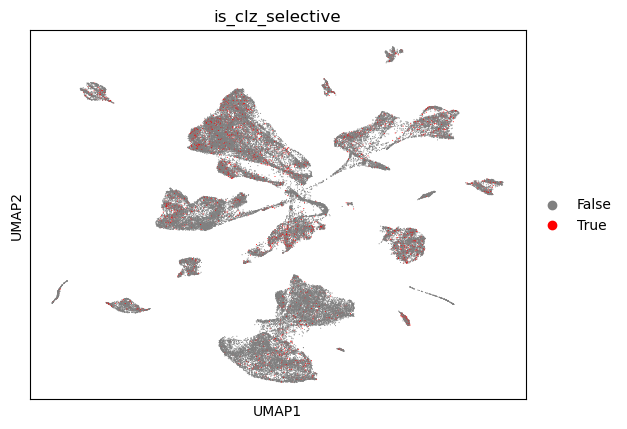

Drug concentration: 3.1622776601683795
clz selective cells
# of clz selective cells: is_clz_selective
False    53168
True      3716
Name: count, dtype: int64


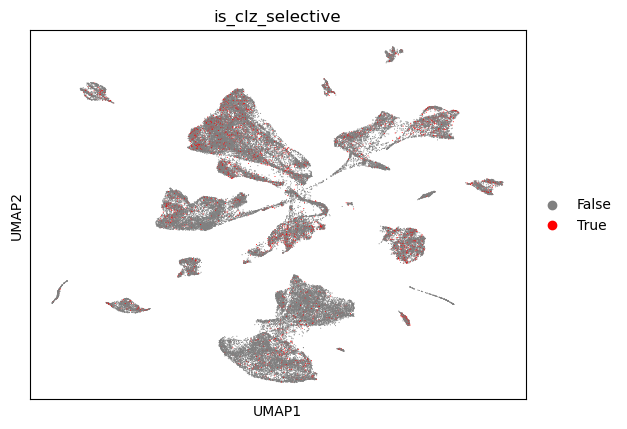

Drug concentration: 5.623413251903491
clz selective cells
# of clz selective cells: is_clz_selective
False    52720
True      4164
Name: count, dtype: int64


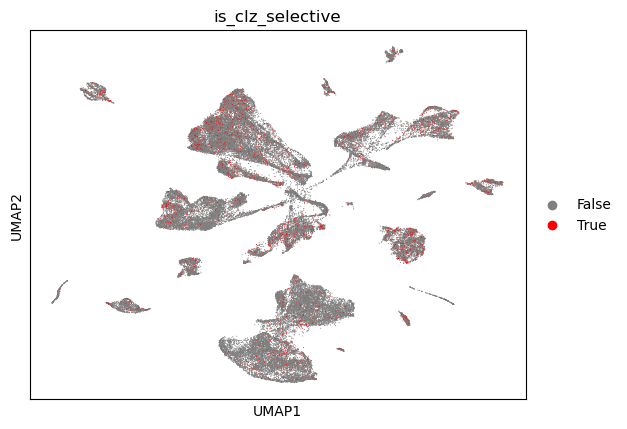

Drug concentration: 10
clz selective cells
# of clz selective cells: is_clz_selective
False    51950
True      4934
Name: count, dtype: int64


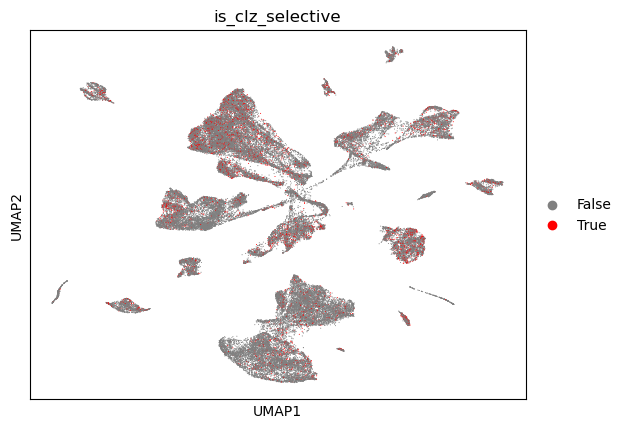

Drug concentration: 31.622776601683793
clz selective cells
# of clz selective cells: is_clz_selective
False    49691
True      7193
Name: count, dtype: int64


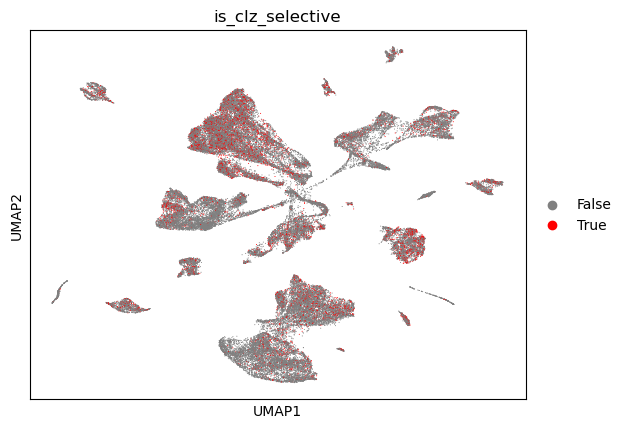

Drug concentration: 100
clz selective cells
# of clz selective cells: is_clz_selective
False    44654
True     12230
Name: count, dtype: int64


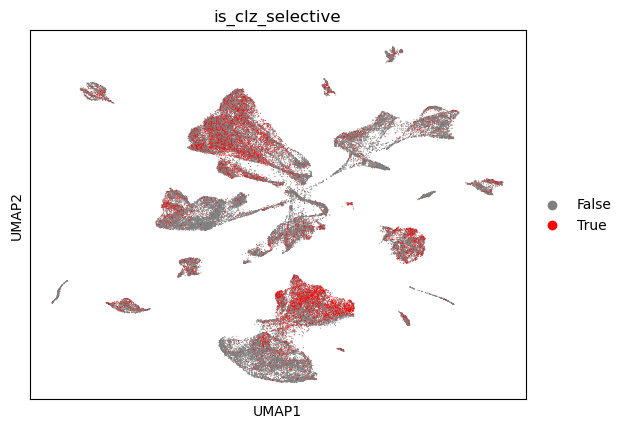

Drug concentration: 316.22776601683796
clz selective cells
# of clz selective cells: is_clz_selective
False    42785
True     14099
Name: count, dtype: int64


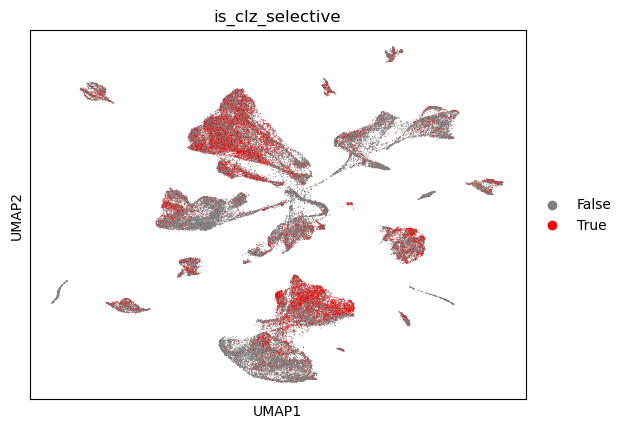

Drug concentration: 1000
clz selective cells
# of clz selective cells: is_clz_selective
False    41193
True     15691
Name: count, dtype: int64


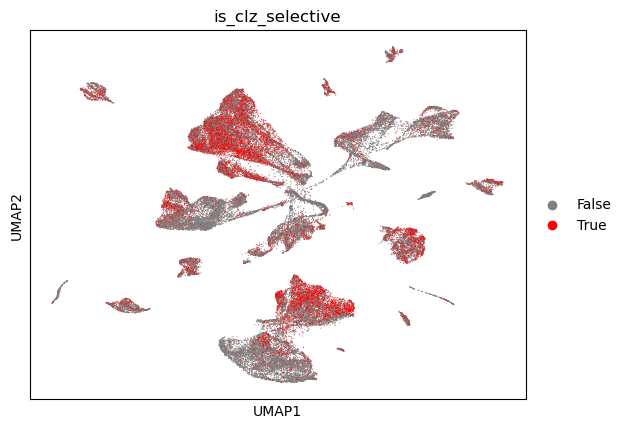

Drug concentration: 10000
clz selective cells
# of clz selective cells: is_clz_selective
False    41055
True     15829
Name: count, dtype: int64


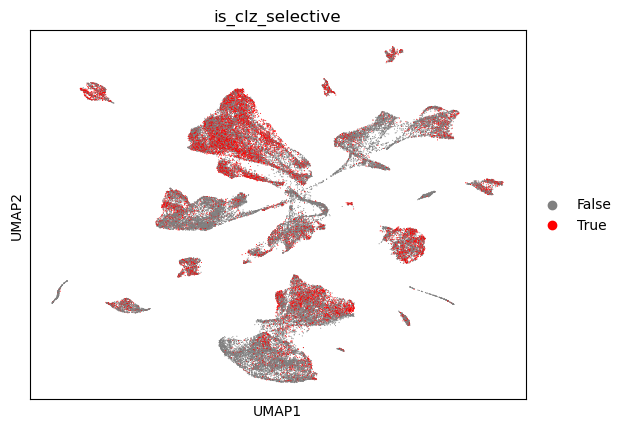

Drug concentration: 100000
clz selective cells
# of clz selective cells: is_clz_selective
False    48794
True      8090
Name: count, dtype: int64


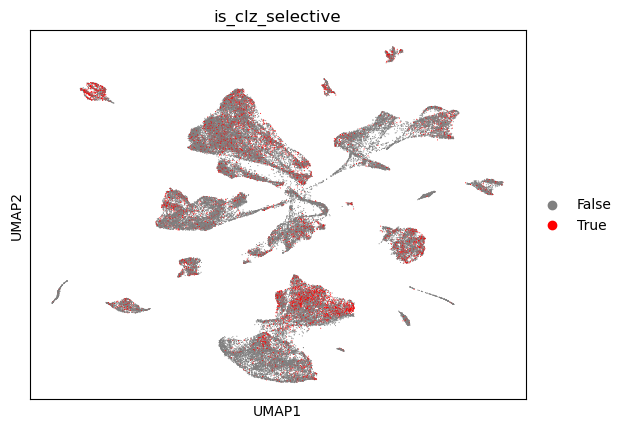

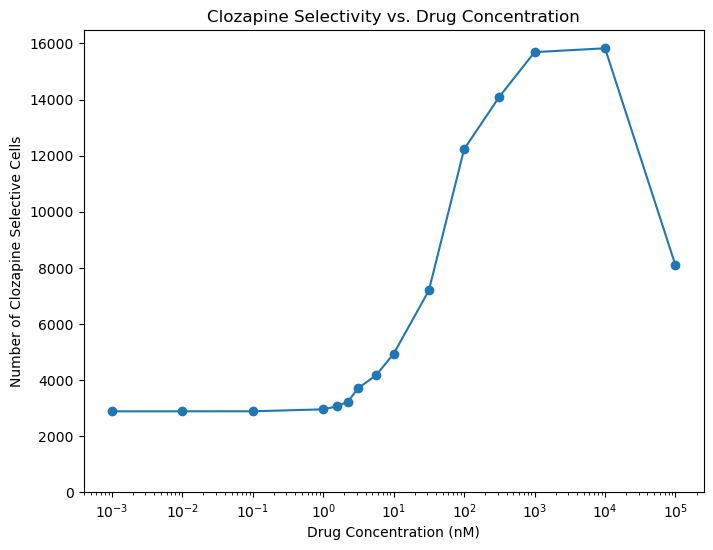

In [4]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)
import calculation_tool as ct
ct.drug_titeration(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx)

clz selective cells
# of clz selective cells: is_clz_selective
False    55470
True      1414
Name: count, dtype: int64


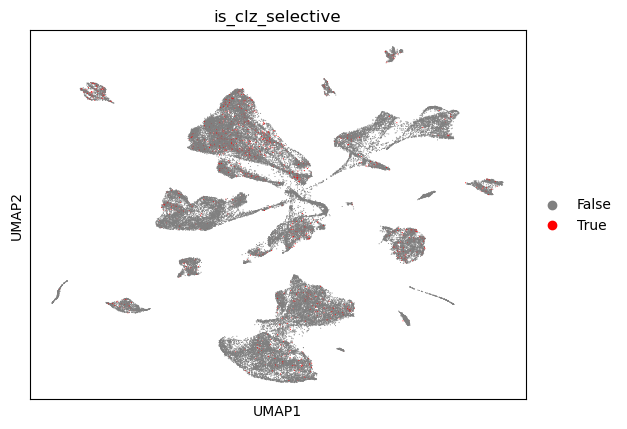

In [5]:
drug_conc=10**4
adata=ct.calc_drug_response(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc)
selectivity_threshold=50
adata,num_clz_selective=ct.calc_clz_selective_cell(adata,drug_list,selectivity_threshold)

In [6]:
file_path="/data/human_Sz_PFC_each/merged_control_selected_adata.h5ad"
file_root, file_extension = os.path.splitext(file_path)
# Append '_processed' to the root and add the extension back
processed_file_path = f"{file_root}_processed{file_extension}"
adata.write(processed_file_path)

In [7]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)

Generating inhibition patterns: 100%|██████████| 3276/3276 [00:00<00:00, 336415.14it/s]


Pattern_1: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False}
Pattern_2: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 

Simulating drug responses: 100%|██████████| 3276/3276 [02:46<00:00, 19.66it/s]


    pattern_name                                            pattern      diff
832  Pattern_833  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.576698
815  Pattern_816  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.562602
902  Pattern_903  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.560078
954  Pattern_955  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.552878
43    Pattern_44  {'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR1E...  0.552675


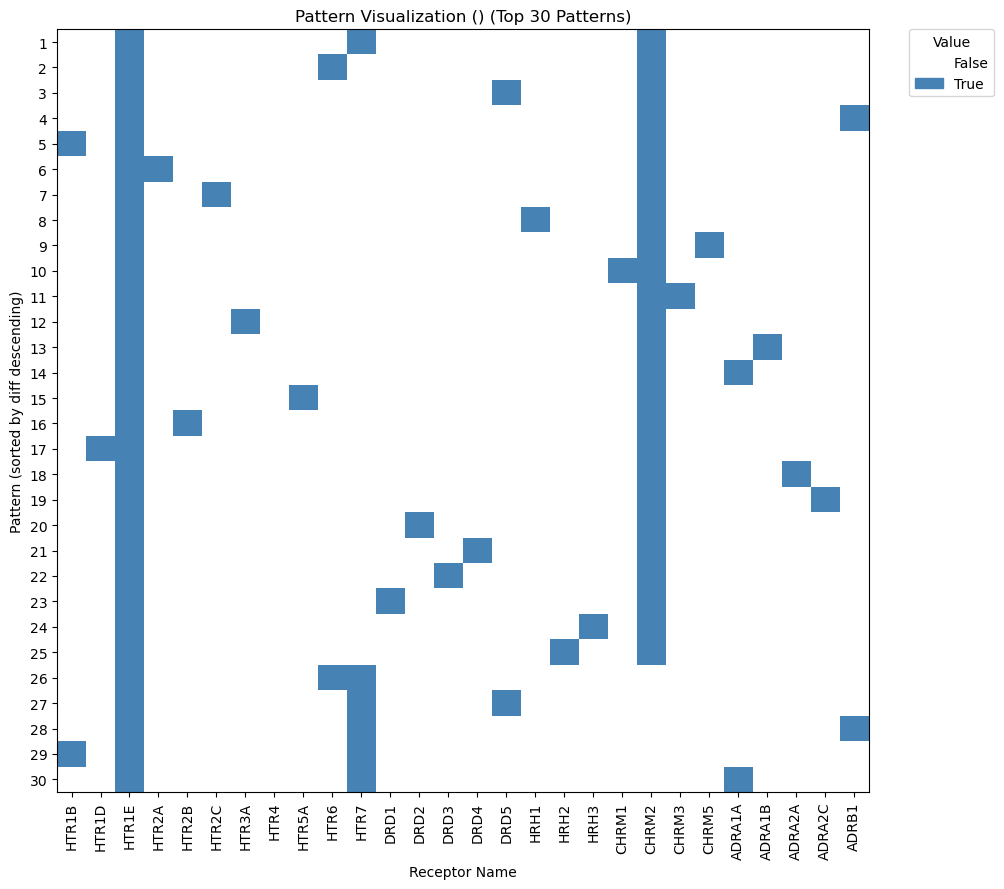

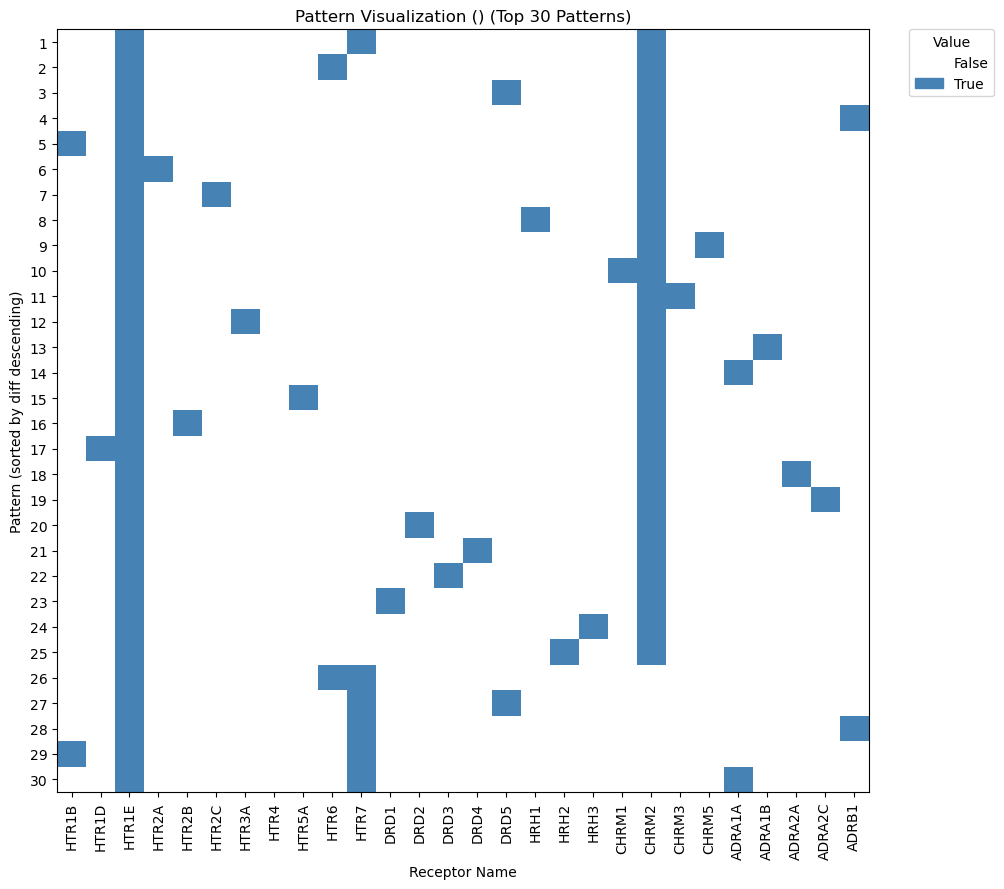

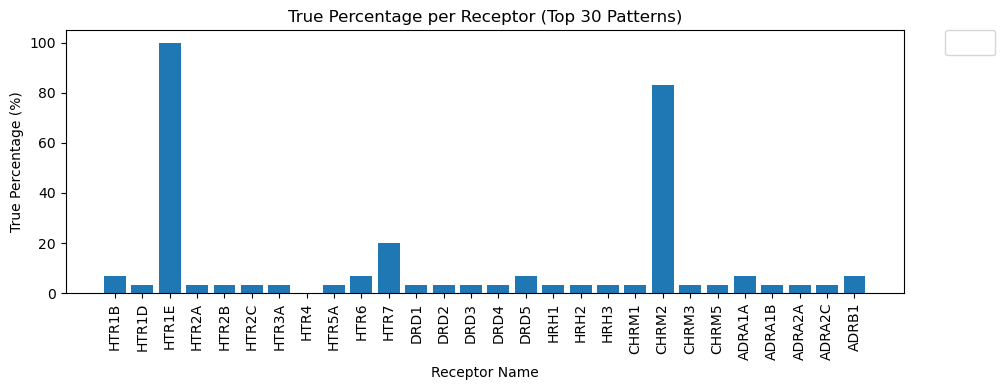

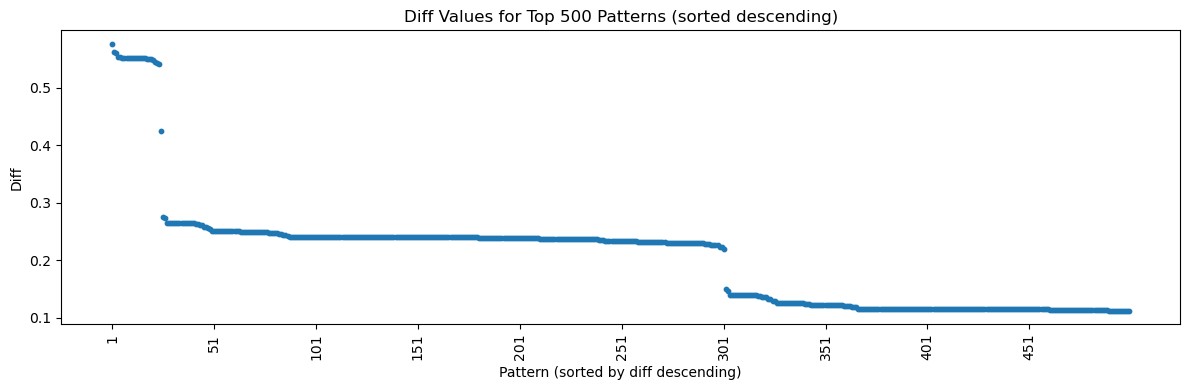

In [8]:
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_clz_selective", selected_label=True,n_inhibited=3)
dir="/data/human_Sz_PFC_each/threshold_50_r_3"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted_3r.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses_3r.csv"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Generating inhibition patterns: 100%|██████████| 20475/20475 [00:00<00:00, 440419.99it/s]


Pattern_1: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False}
Pattern_2: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'C

Simulating drug responses: 100%|██████████| 20475/20475 [17:04<00:00, 19.99it/s]


      pattern_name                                            pattern  \
6865  Pattern_6866  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...   
7071  Pattern_7072  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...   
7123  Pattern_7124  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...   
481    Pattern_482  {'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR1E...   
7119  Pattern_7120  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...   

          diff  
6865  0.586797  
7071  0.584273  
7123  0.577073  
481   0.576870  
7119  0.576698  


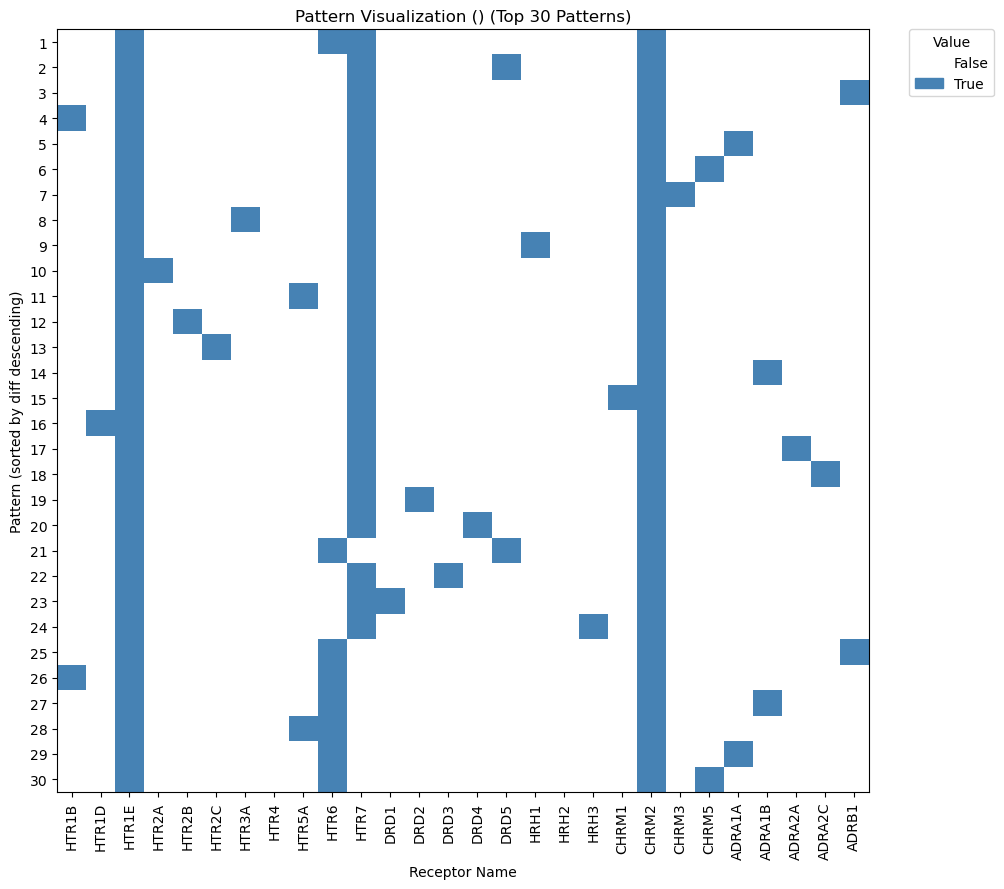

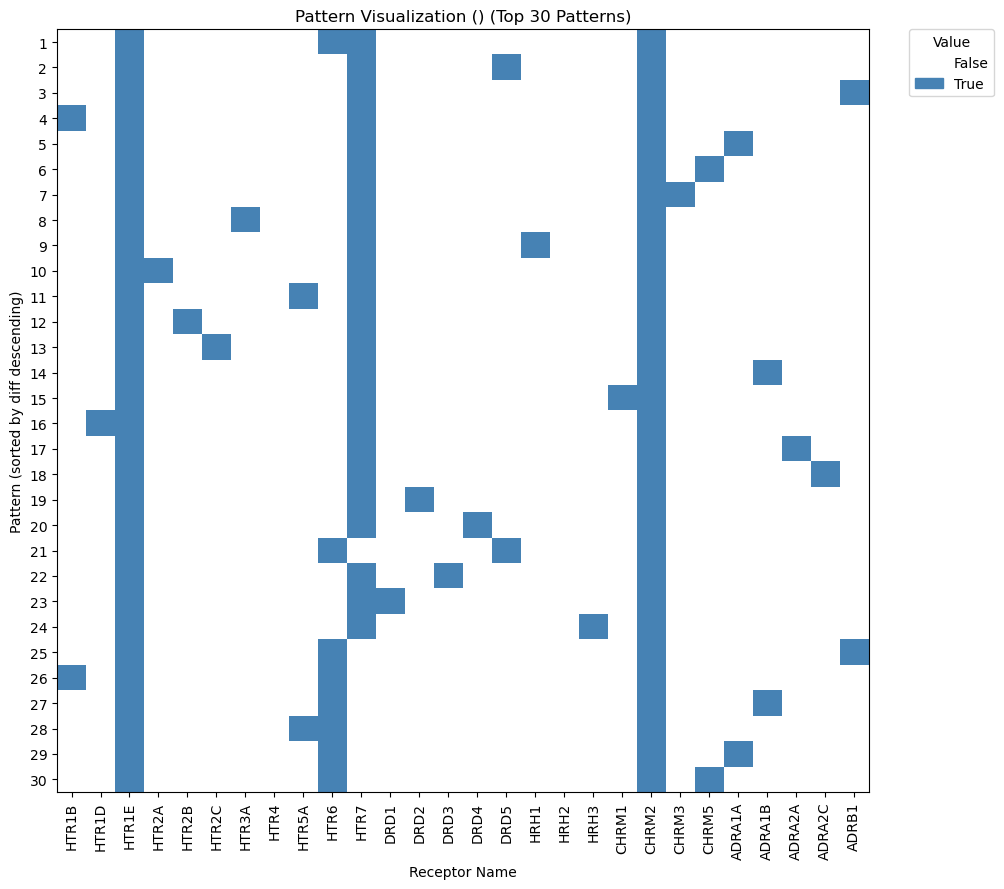

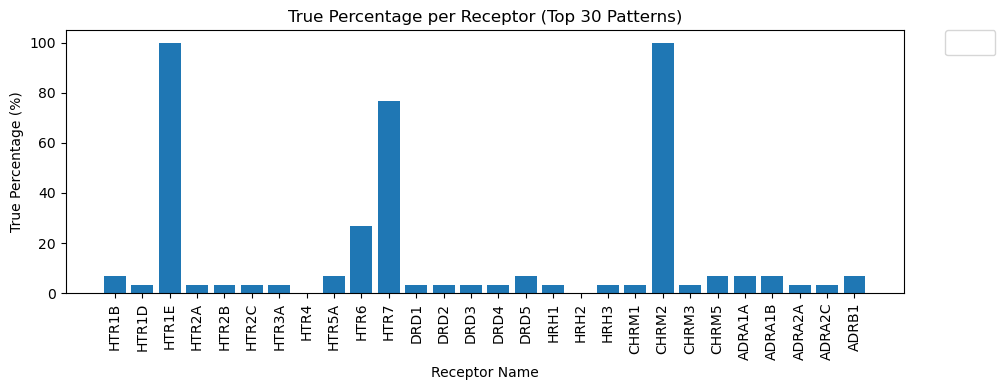

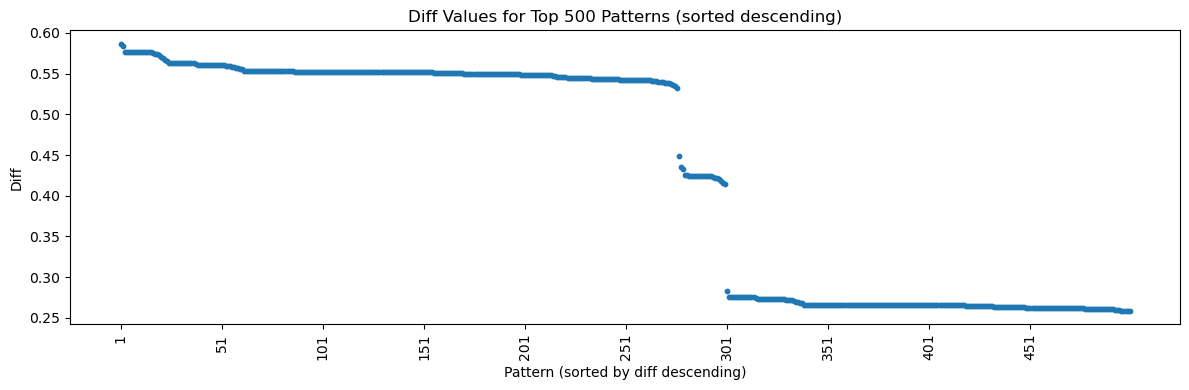

In [9]:
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_clz_selective", selected_label=True,n_inhibited=4)
dir="/data/human_Sz_PFC_each/threshold_50_r_4"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted_3r.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses_3r.csv"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

In [10]:
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_clz_selective", selected_label=True,n_inhibited=5)
dir="/data/human_Sz_PFC_each/threshold_50_r_5"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted_3r.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses_3r.csv"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Generating inhibition patterns: 100%|██████████| 98280/98280 [00:00<00:00, 317792.19it/s]


Pattern_1: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False}
Pattern_2: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': True, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHR

Simulating drug responses:   5%|▌         | 5281/98280 [04:25<1:18:00, 19.87it/s]


KeyboardInterrupt: 

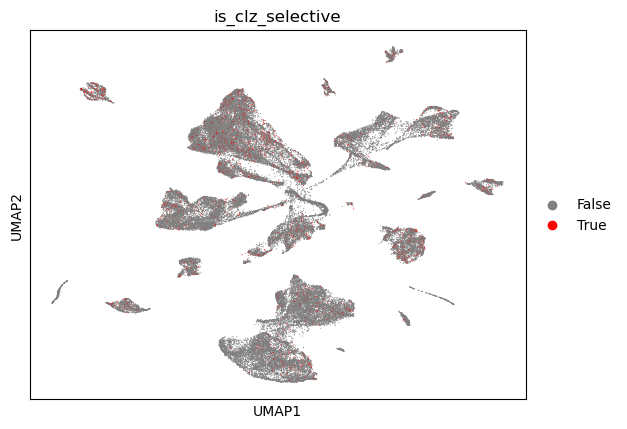

In [17]:
sc.pl.umap(adata, color=["is_clz_selective"])

In [18]:
#import calculation_tool as ct

drug_conc=10**4
results_df_sorted,all_responses=ct.sim_inhibit_pattern(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,n_pattern=10000)

Pattern_1: {'HTR1B_raw': False, 'HTR1D_raw': True, 'HTR1E_raw': False, 'HTR2A_raw': False, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': True, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': True, 'DRD1_raw': True, 'DRD2_raw': True, 'DRD3_raw': True, 'DRD4_raw': True, 'DRD5_raw': True, 'HRH1_raw': True, 'HRH2_raw': True, 'HRH3_raw': True, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': True, 'ADRA1B_raw': True, 'ADRA2A_raw': True, 'ADRA2C_raw': False, 'ADRB1_raw': False}
Pattern_2: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': True, 'HTR4_raw': False, 'HTR5A_raw': True, 'HTR6_raw': True, 'HTR7_raw': True, 'DRD1_raw': False, 'DRD2_raw': True, 'DRD3_raw': False, 'DRD4_raw': True, 'DRD5_raw': True, 'HRH1_raw': False, 'HRH2_raw': True, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': True, 'AD

Simulating drug responses: 100%|██████████| 10000/10000 [06:39<00:00, 25.00it/s]

      pattern_name                                            pattern  \
2157  Pattern_2158  {'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR1E...   
4219  Pattern_4220  {'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR1E...   
4089  Pattern_4090  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...   
4379  Pattern_4380  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...   
8471  Pattern_8472  {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_...   

          diff  
2157  0.447136  
4219  0.445174  
4089  0.443566  
4379  0.443566  
8471  0.443497  


In [19]:
dir="/data/human_Sz_PFC_each/control_selected"
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses.csv"))

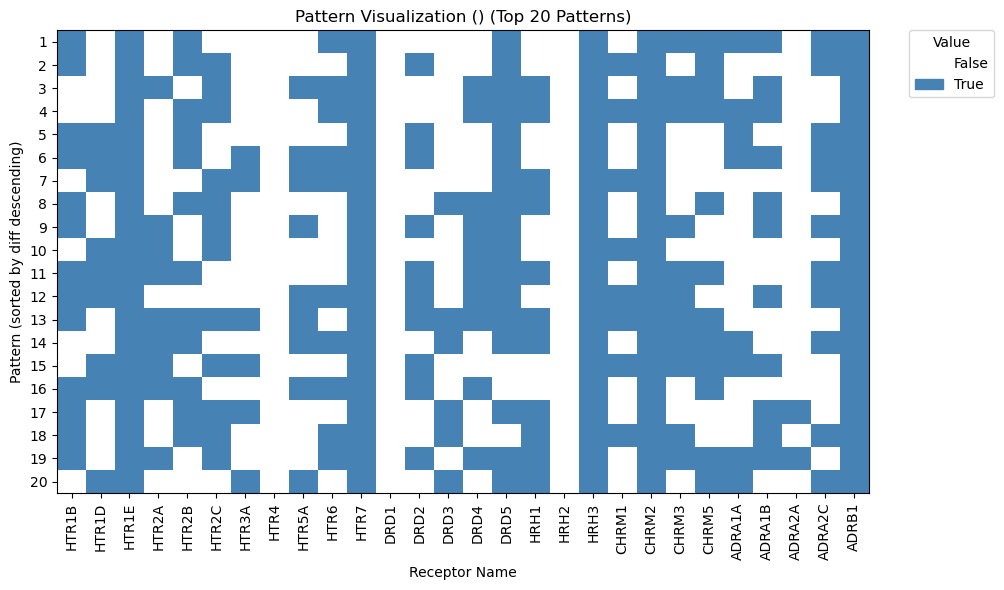

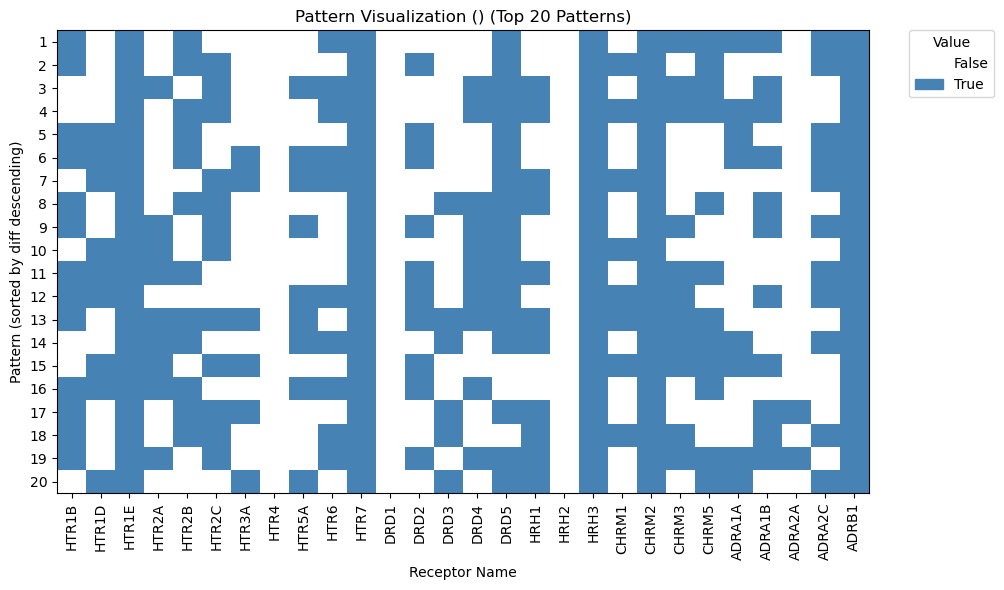

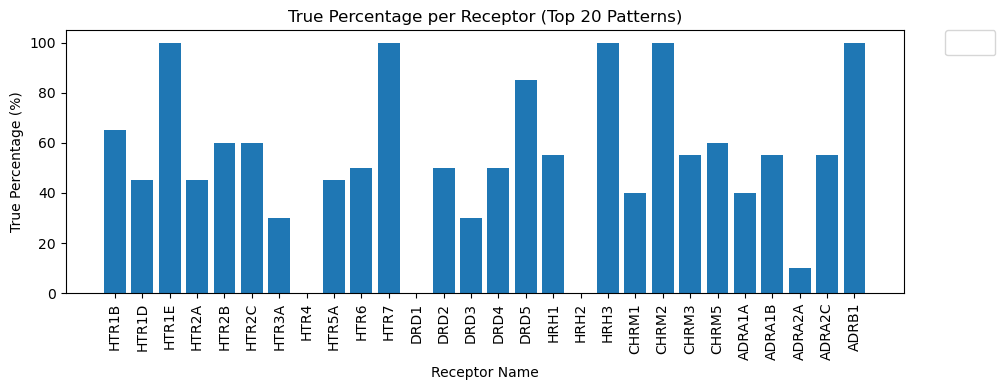

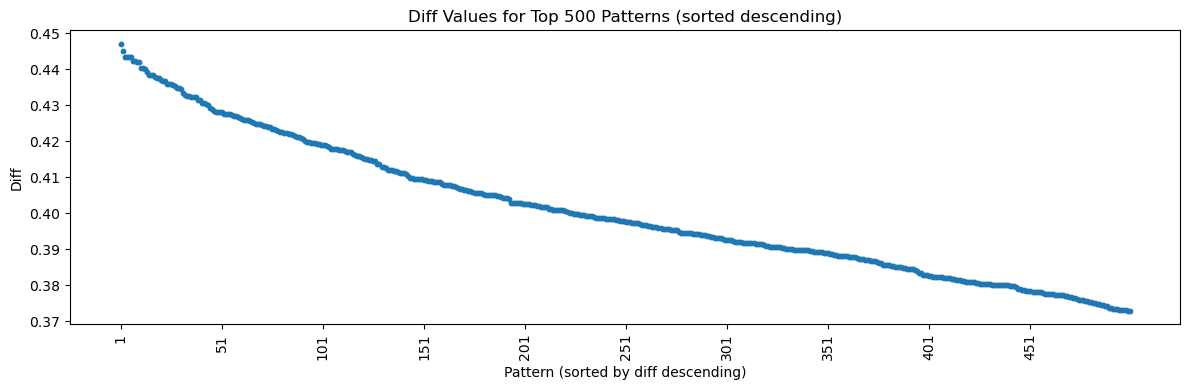

In [20]:
ct.visualize_patterns(results_df_sorted, top_n=20, top_n_for_heatmap=20, scatter_n=500)

In [14]:
import calculation_tool as ct

drug_conc=10**4
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc)

Generating inhibition patterns: 100%|██████████| 3276/3276 [00:00<00:00, 268537.76it/s]


Pattern_1: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False}
Pattern_2: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 

Simulating drug responses:   0%|          | 0/3276 [00:00<?, ?it/s]

Simulating drug responses: 100%|██████████| 3276/3276 [02:29<00:00, 21.97it/s]

    pattern_name                                            pattern      diff
932  Pattern_933  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.396995
832  Pattern_833  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.394503
954  Pattern_955  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.380971
902  Pattern_903  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.369826
43    Pattern_44  {'HTR1B_raw': True, 'HTR1D_raw': False, 'HTR1E...  0.368372


In [15]:
dir="/data/human_Sz_PFC_each/"
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted_3r.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses_3r.csv"))

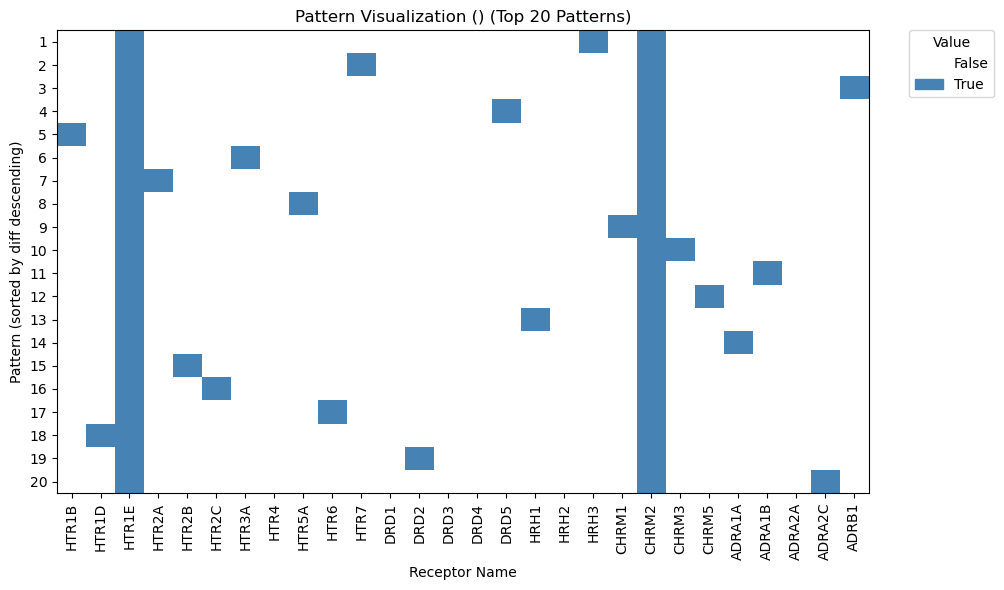

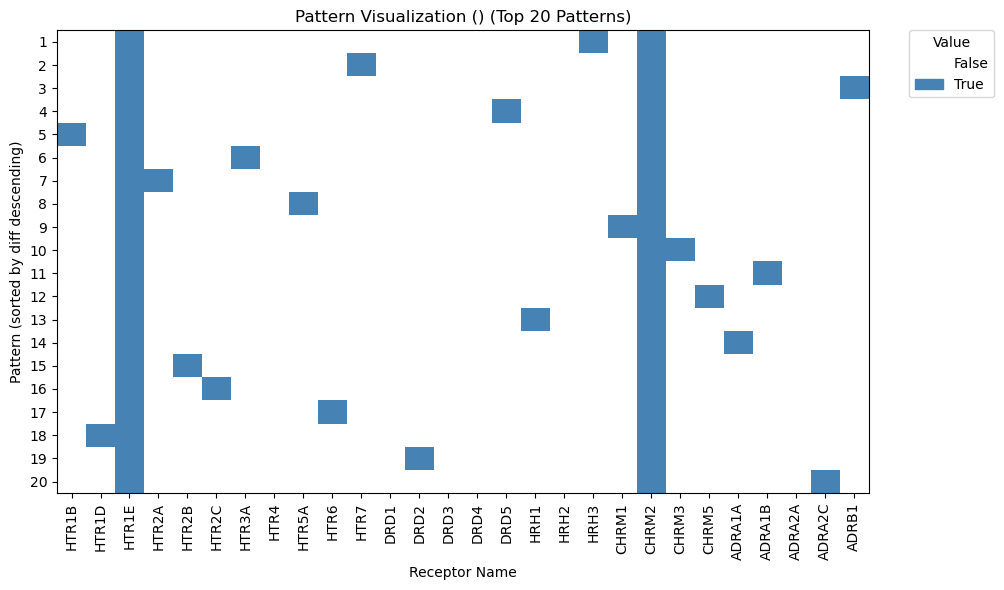

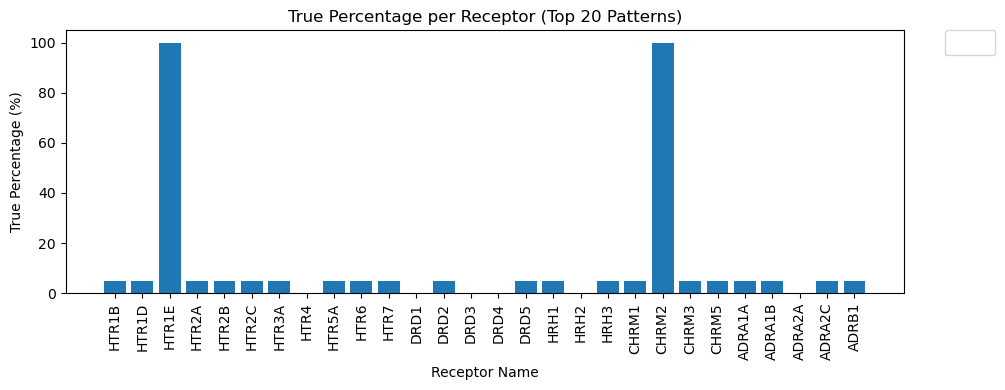

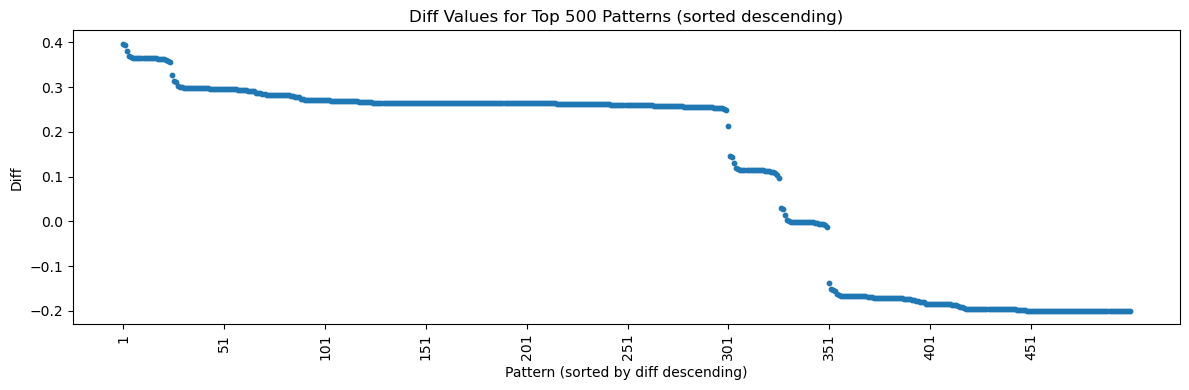

In [16]:
ct.visualize_patterns(results_df_sorted, top_n=20, top_n_for_heatmap=20, scatter_n=500)

clz selective cells
# of clz selective cells: is_clz_selective
False    55850
True      1034
Name: count, dtype: int64


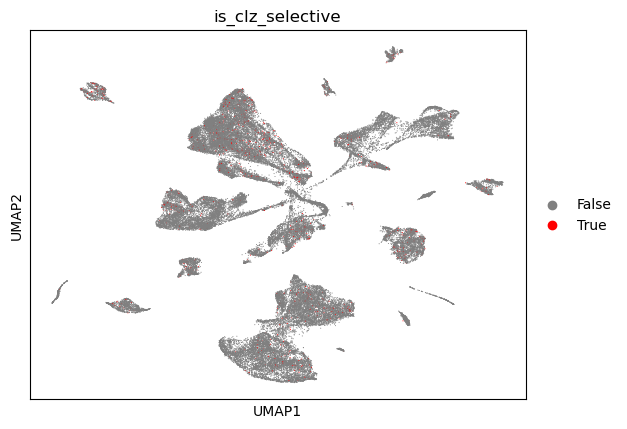

In [11]:
drug_conc=10**4
adata=ct.calc_drug_response(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc)
selectivity_threshold=100
adata,num_clz_selective=ct.calc_clz_selective_cell(adata,drug_list,selectivity_threshold)

Generating inhibition patterns: 100%|██████████| 3276/3276 [00:00<00:00, 270813.59it/s]


Pattern_1: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False}
Pattern_2: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 

Simulating drug responses:   0%|          | 0/3276 [00:00<?, ?it/s]

Simulating drug responses: 100%|██████████| 3276/3276 [02:41<00:00, 20.25it/s]


    pattern_name                                            pattern      diff
832  Pattern_833  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.563947
815  Pattern_816  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.552630
902  Pattern_903  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.549989
954  Pattern_955  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.546896
952  Pattern_953  {'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1...  0.544392


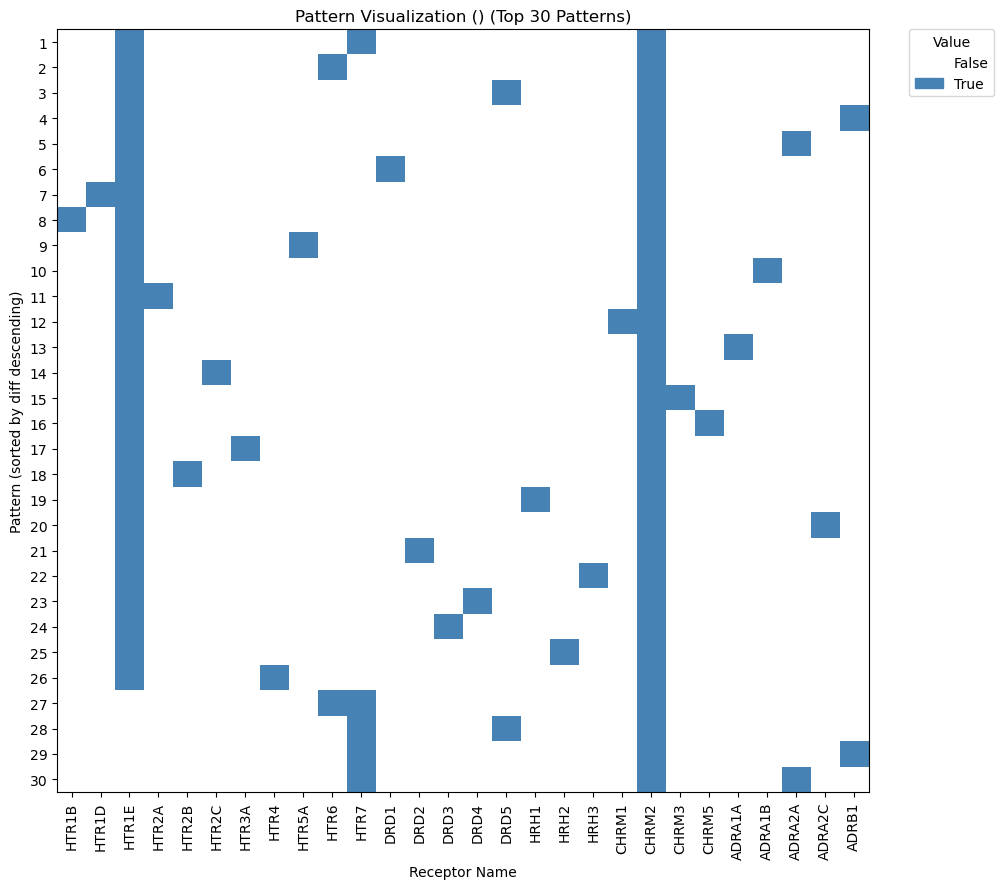

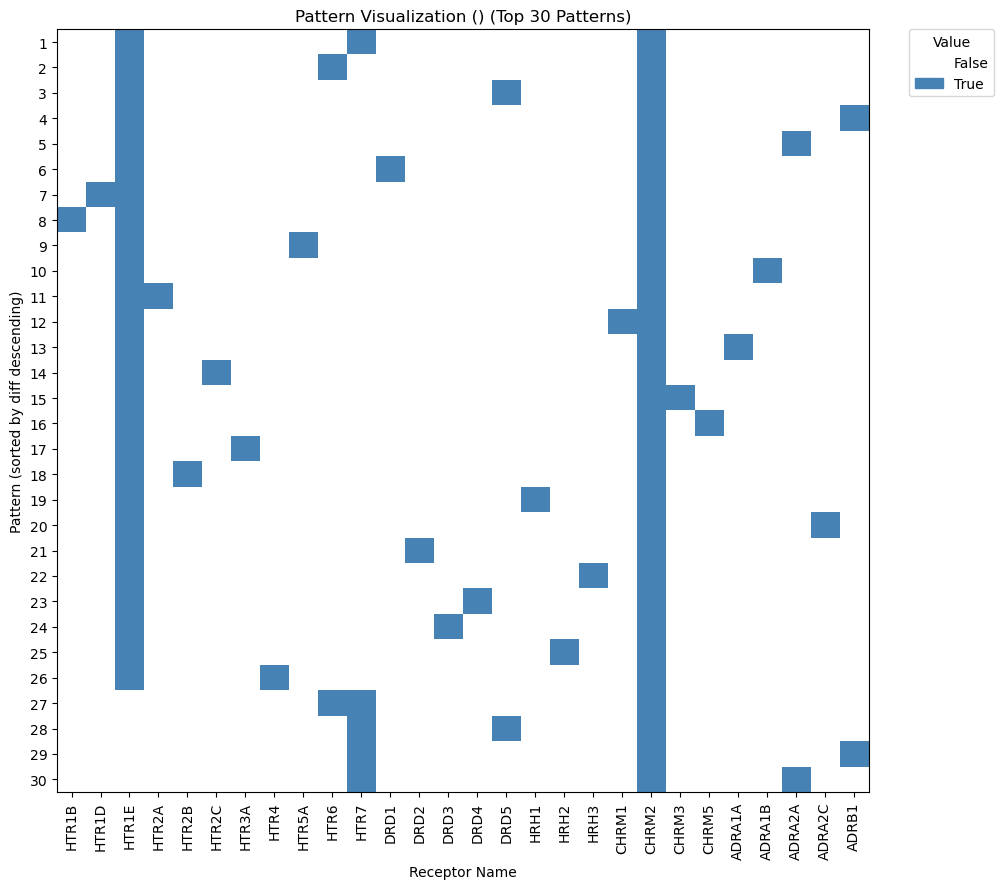

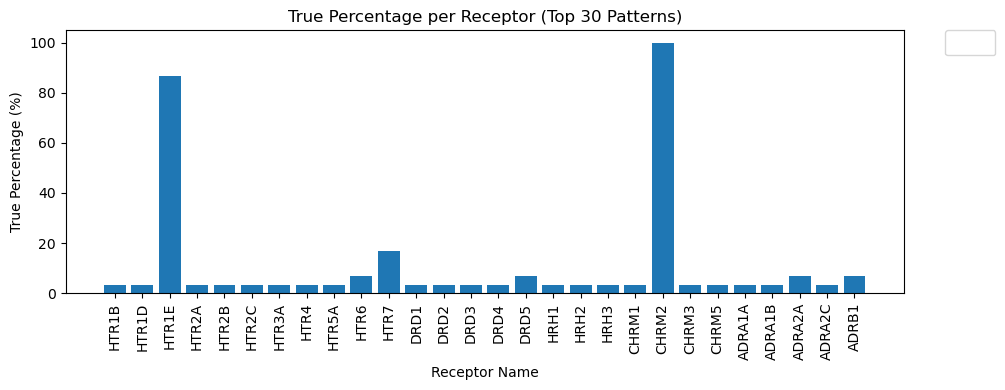

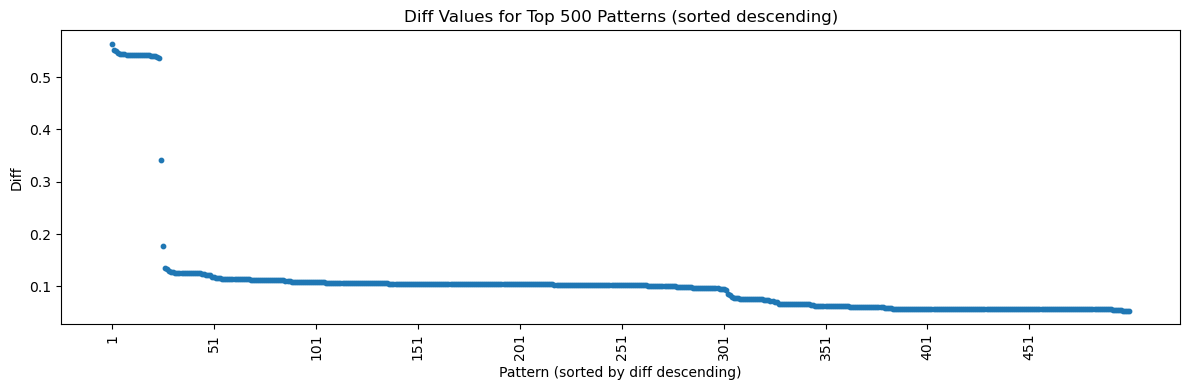

In [12]:
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_clz_selective", selected_label=True,n_inhibited=3)
dir="/data/human_Sz_PFC_each/threshold_100_r_3"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted_3r.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses_3r.csv"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

In [ ]:
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_clz_selective", selected_label=True,n_inhibited=4)
dir="/data/human_Sz_PFC_each/threshold_100_r_4"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted_3r.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses_3r.csv"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Generating inhibition patterns: 100%|██████████| 20475/20475 [00:00<00:00, 271491.22it/s]


Pattern_1: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False}
Pattern_2: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': True, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'C

Simulating drug responses:   0%|          | 0/20475 [00:00<?, ?it/s]

Simulating drug responses:  65%|██████▌   | 13367/20475 [09:33<05:17, 22.40it/s]

clz selective cells
# of clz selective cells: is_clz_selective
False    55850
True      1034
Name: count, dtype: int64


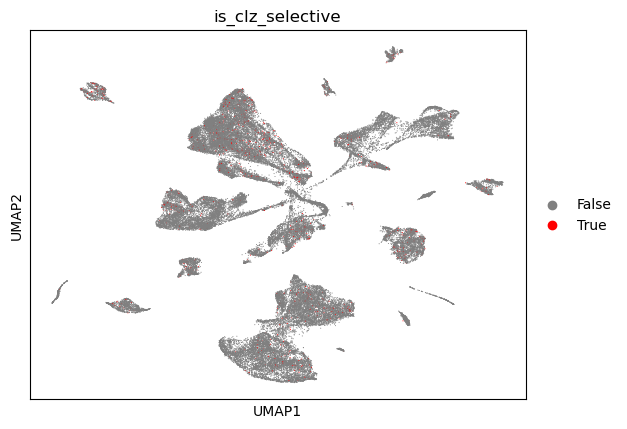

In [ ]:
drug_conc=10**4
adata=ct.calc_drug_response(adata,GPCR_df,GPCR_type_df,drug_list,D_R_mtx,drug_conc)
selectivity_threshold=500
adata,num_clz_selective=ct.calc_clz_selective_cell(adata,drug_list,selectivity_threshold)

In [ ]:
results_df_sorted,all_responses=ct.sim_inhibit_pattern_3r(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,group_col="is_clz_selective", selected_label=True,n_inhibited=3)
dir="/data/human_Sz_PFC_each/threshold_100_r_3"
if not os.path.exists(dir):
    os.makedirs(dir)
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted_3r.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses_3r.csv"))
ct.visualize_patterns(results_df_sorted, top_n=30, top_n_for_heatmap=30, scatter_n=500)

Generating inhibition patterns: 100%|██████████| 3276/3276 [00:00<00:00, 270813.59it/s]


Pattern_1: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': True, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM5_raw': False, 'ADRA1A_raw': False, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2C_raw': False, 'ADRB1_raw': False}
Pattern_2: {'HTR1B_raw': True, 'HTR1D_raw': True, 'HTR1E_raw': False, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': False, 'HTR3A_raw': False, 'HTR4_raw': False, 'HTR5A_raw': False, 'HTR6_raw': False, 'HTR7_raw': False, 'DRD1_raw': False, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': False, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': False, 'HRH3_raw': False, 'CHRM1_raw': False, 'CHRM2_raw': False, 'CHRM3_raw': False, 

Simulating drug responses:   0%|          | 0/3276 [00:00<?, ?it/s]

Simulating drug responses: 100%|██████████| 3276/3276 [02:41<00:00, 20.25it/s]
